### Data parameter setup

In [1]:
import copy
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import time
from datetime import date
import os
import keypoint_moseq as kpms
import keypoint_moseq .analysis as kpmsa
from collections import OrderedDict
import sys
# sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/AVATAR_motionMap')
# import FileManager.csvload as acl

# parameters setup
project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21'                     # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
SIT_info_path = r'T:\2.실험데이터\AVATAR-SDSBD\AVATAR_SDSBD총정리_usedForAnalysis_저용량.xlsx'

In [2]:
# 'SI ratio' loading
def import_SIT_params(SIT_info_path):
    df = pd.read_excel(SIT_info_path)
    my_dict = dict(zip(df['mouse_name'], df['SIratio_z_score']))
    return my_dict
SIT_params = import_SIT_params(SIT_info_path)

# 'stats_df' loading
stats_df = pd.read_csv(os.path.join(project_dir, model_name, 'stats_df_z1.5.csv'))

# merge SIT_params and stats_df
SIT_params_updated = {f'pre{k}': v for k, v in SIT_params.items()}
stats_df_SIT = stats_df.copy()
stats_df_SIT['SI_ratio'] = stats_df_SIT['name'].map(SIT_params_updated)     # Map SI_ratio value in SIT_params_updated based on 'name' column
# Create a list of columns, place them in the following order: 'name', 'SI_ratio', 'frequency', 'duration' and add the remaining columns
columns_reordered = ['group', 'name', 'SI_ratio', 'syllable', 'frequency', 'duration'] + \
                    [col for col in stats_df.columns if col not in ['group', 'name', 'SI_ratio', 'syllable', 'frequency', 'duration']]  
stats_df_SIT = stats_df_SIT[columns_reordered]

stats_df_SIT

,group,name,SI_ratio,syllable,frequency,duration,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,angular_velocity_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max
0,control,pre101,-0.236979,0,0.121726,0.525949,0.300114,1.743290,-3.065187,3.126728,0.041151,6.183400,-124.841955,123.798028,15.734908,6.663298,2.343172,42.528489
1,control,pre101,-0.236979,1,0.077042,0.403000,0.192304,1.486307,-3.137526,3.114187,0.123514,6.251990,-122.839748,3.408401,16.852922,7.153993,1.992306,39.493306
2,control,pre101,-0.236979,2,0.072419,0.369149,0.305774,1.851624,-3.121521,3.113962,-0.053589,11.705295,-125.537627,125.488394,16.218228,6.830357,1.771851,35.085959
3,control,pre101,-0.236979,3,0.070878,0.722826,-0.036918,1.882042,-3.125108,3.133265,0.129068,10.886630,-125.438351,125.350329,16.602214,7.346626,1.620029,49.299980
4,control,pre101,-0.236979,4,0.084746,1.069091,-0.087757,1.867114,-3.129096,3.135656,0.016667,11.494598,-125.091086,125.204968,15.457976,6.398990,0.591141,42.712148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,susceptible,pre515,-2.942013,15,0.005076,0.960000,-0.905697,1.324931,-2.395697,2.350345,0.150789,0.362615,-0.446533,1.214727,14.136171,6.093409,2.300460,32.958347
1496,susceptible,pre515,-2.942013,17,0.009137,0.888889,-0.612740,1.902266,-2.557037,2.978161,-0.490278,0.868048,-2.846438,1.904925,15.140513,6.754004,1.447173,35.626160
1497,susceptible,pre515,-2.942013,18,0.016244,0.909375,-0.287941,2.311465,-3.093878,3.114922,0.160539,10.439447,-125.275594,125.372726,16.031630,6.930466,2.407287,41.912190
1498,susceptible,pre515,-2.942013,23,0.001015,0.450000,2.632228,0.253962,2.224416,2.839604,1.392337,0.468993,0.634371,1.849669,19.154705,9.544158,3.718650,32.040707


In [3]:
stats_df_SIT.to_csv(os.path.join(project_dir, model_name, 'stats_df_SIT_z1.5.csv'), index=False)

Data processing for a classifier

In [3]:
# Load data
df = stats_df_SIT
base_columns = ['group', 'name', 'SI_ratio', 'syllable']

# Check if the DataFrame contains all the required columns.
missing_columns = [col for col in base_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Error: Missing required columns in the dataframe: {missing_columns}")    # Check for missing required columns and raise an error message if any are missing.
else:
    print("All required columns are present.")

# Get the unique values of syllables
syllables = df['syllable'].unique()

# Initialize with the first syllable data
syll = sorted(syllables)[0]
final_df = df[df['syllable'] == syll].copy()
rename_cols = {col: f"{col}_syll{syll}" for col in final_df.columns if col not in base_columns}
final_df.rename(columns=rename_cols, inplace=True)
final_df.drop(['syllable'], axis=1, inplace=True)

for syll in sorted(syllables)[1:]:
    syll_data = df[df['syllable'] == syll].copy()
    rename_cols = {col: f"{col}_syll{syll}" for col in syll_data.columns if col not in base_columns}
    syll_data.rename(columns=rename_cols, inplace=True)
    syll_data.drop(['group', 'SI_ratio', 'syllable'], axis=1, inplace=True)

    # Merge based on 'name'
    final_df = pd.merge(final_df, syll_data, on='name', how='outer', suffixes=('', f'_syll{syll}'))

# Check for and remove duplicated columns
duplicated_columns = final_df.columns[final_df.columns.duplicated()]
if not duplicated_columns.empty:
    print(f"Warning: Duplicated columns detected - {duplicated_columns.tolist()}")
    final_df = final_df.loc[:,~final_df.columns.duplicated()]

# Fill NaN values of 'frequency' with 0
for col in final_df.columns:
    if col.startswith('frequency_syll'):
        final_df[col].fillna(0, inplace=True)

print(final_df.head())

All required columns are present.
     group    name  SI_ratio  frequency_syll0  duration_syll0  \
0  control  pre101 -0.236979         0.121726        0.525949   
1  control  pre104  0.657345         0.131448        0.621519   
2  control  pre105  0.568205         0.137731        0.418908   
3  control  pre110 -2.143298         0.134228        0.608125   
4  control  pre201 -0.679408         0.138462        0.548718   

   heading_mean_syll0  heading_std_syll0  heading_min_syll0  \
0            0.300114           1.743290          -3.065187   
1            0.001352           1.606963          -3.133848   
2            0.211494           1.885233          -3.113404   
3           -0.107958           1.824542          -3.132888   
4           -0.105431           1.883251          -3.127138   

   heading_max_syll0  angular_velocity_mean_syll0  ...  heading_min_syll24  \
0           3.126728                     0.041151  ...            0.441818   
1           3.135569                    

In [4]:
final_df.to_csv(os.path.join(project_dir, model_name, 'final_df_z1.5.csv'), index=False)

Plot bar graph representing mean frequency between groups (optional)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# final_df를 예제 데이터 프레임으로 가정
# 예: final_df = pd.read_csv("/path/to/your/final_df.csv")
# 특정 syllables 지정
syllables_to_plot = ['frequency_syll3', 'frequency_syll12', 'frequency_syll15']

# resilient과 susceptible 그룹의 데이터만 필터링
df_filtered = final_df[final_df['group'].isin(['resilient', 'susceptible'])]

# Plot 설정
n_syllables = len(syllables_to_plot)
fig, axes = plt.subplots(n_syllables, 1, figsize=(3, n_syllables * 5))

for i, syllable in enumerate(syllables_to_plot):
    # 현재 subplot 선택
    ax = axes[i]
    
    # 바 그래프를 그리기 위한 평균 데이터 준비
    mean_data = df_filtered.groupby('group')[syllable].mean().reset_index()
    
    # 바 그래프 그리기
    sns.barplot(data=mean_data, x='group', y=syllable, ax=ax, palette=['blue', 'green'], alpha=0.6)
    
    # 개별 포인트 그리기
    for j, group in enumerate(['resilient', 'susceptible']):
        group_data = df_filtered[df_filtered['group'] == group]
        x = np.full(group_data.shape[0], j)  # 모든 포인트에 대해 x 위치 설정
        ax.scatter(x, group_data[syllable], color='k', alpha=0.7)

    # 라벨과 제목 설정
    ax.set_ylabel(f'Frequency of {syllable}')
    ax.set_title(f'Comparison of {syllable} Between Groups')
    ax.set_xticklabels(['Resilient', 'Susceptible'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Classifier

### MotionMapper, scalar summaries와 동일한 classifier (SDSBD논문) - Logistic regression

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
np.random.seed(42)
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/AVATAR_motionMap')
import Calculator.stats as ccs

group1 = 'resilient'
group2 = 'susceptible'
groups = [group1, group2]
#feature_columns = final_df.filter(regex='^frequency_syll').columns.tolist()
#feature_columns = ['frequency_syll3','frequency_syll12','frequency_syll15']
feature_columns = ['frequency_syll3','frequency_syll12']
data_processed = final_df

# 데이터 준비
filtered_df = data_processed[(data_processed['group'] == group1) | (data_processed['group'] == group2)].copy() # resil, suscep만 추출
# filtered_df 순서를 무작위로 섞기
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)
X = filtered_df[feature_columns]    # frequency만 features로 사용

label_mapping = {'resilient': 0, 'susceptible': 1}
filtered_df['group'] = filtered_df['group'].map(label_mapping)
y = filtered_df['group'].values

In [49]:
# 경로 설정
folder_path_scalar = r'T:\2.실험데이터\AVATAR-SDSBD\dataset5'
variables = ['moseq_3,12']
variable = variables[0]
prcurve_linspace = 200 # Precision-Recall 곡선을 그릴 때 사용할 linspace 개수

# Repeated Stratified K-Fold cross-validator
n_splits = 5
n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

In [50]:
plt.figure(figsize=(10, 8)) # Precision-Recall 곡선 그리기 준비
colors = plt.cm.get_cmap('tab10', len(variables)) # 변수별로 다른 색상 사용

all_f1_scores = {}  # F1 score 저장할 딕셔너리
all_random_f1_scores = {}  # Random label에 대한 F1 score 저장할 딕셔너리

# 실제 분류 수행
f1_scores, real_cm, real_precisions, real_recalls, real_auc = ccs.run_classification(X_scaled, y, validator=rskf, 
                                                                                        prcurve_linspace=prcurve_linspace, 
                                                                                        class_weight=class_weight_dict, random=False)
f1_scores_mean = np.array(f1_scores).reshape(-1, n_splits).mean(axis=1)
# f1_scores_mean = f1_scores
all_f1_scores[variable] = f1_scores_mean
f1_mean = np.mean(f1_scores_mean)
f1_std_err = np.std(f1_scores_mean) / np.sqrt(len(f1_scores_mean))

# Random label에 대한 분류 수행
# y_random = shuffle(y.copy(), random_state=np.random.randint(1000))
random_f1_scores, _, _, _, _ = ccs.run_classification(X_scaled, y, validator=rskf,
                                                        prcurve_linspace=prcurve_linspace, class_weight=class_weight_dict, random=True)
random_f1_scores_mean = np.array(random_f1_scores).reshape(-1, n_splits).mean(axis=1)
# random_f1_scores_mean = random_f1_scores
all_random_f1_scores[variable] = random_f1_scores_mean

# 결과 출력
print(f"Variable: {variable}")
print(f"Number of samples: {len(filtered_df)}")
print(f"Number of features: {X.shape[1]}")
print("\nClassification Results:")
print(f"F1 Score: {f1_mean:.4f} ± {f1_std_err:.4f}")
print(f"Real AUC Score: {real_auc:.4f}")

print("\nConfusion Matrix:")
print(real_cm)

# Precision-Recall 곡선 그리기
mean_precision = np.linspace(0, 1, prcurve_linspace)
mean_recall = np.zeros_like(mean_precision)
for precision, recall in zip(real_precisions, real_recalls):
    interp_precision = np.interp(mean_precision, precision, recall)
    mean_recall += interp_precision
mean_recall /= len(real_precisions)
plt.plot(mean_precision, mean_recall, color=colors.colors[0], linewidth=2, label=f"{variable} (F1 Score: {f1_mean:.4f} ± {f1_std_err:.4f})")

# Confusion Matrix 저장 (논문 방식)
cm_normalized = real_cm.astype('float') / real_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, cmap=plt.cm.Greys, vmin=0, vmax=1)
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(groups)), groups)
plt.yticks(range(len(groups)), groups)
for i in range(len(groups)):
    for j in range(len(groups)):
        plt.text(j, i, f"{cm_normalized[i, j]:.2f}", ha='center', va='center', color='white' if cm_normalized[i, j] > 0.5 else 'black')
plt.title(f'Confusion Matrix ({variable})')
plt.colorbar(label='Classification Rate')
plt.savefig(os.path.join(folder_path_scalar, 'figure_scalar', f'{variable}_confusion_matrix_normalized.png'))
plt.savefig(os.path.join(folder_path_scalar, 'figure_scalar', f'{variable}_confusion_matrix_normalized.pdf'))
plt.close()

# 실제 F1 score와 random label에 대한 F1 score 비교 (t-test)
t_statistic, p_value = ttest_rel(f1_scores_mean, random_f1_scores_mean)
print(f"\nStatistical Significance (t-test) - {variable}:")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Precision-Recall 곡선 완성 및 저장
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend()
plt.savefig(os.path.join(folder_path_scalar, 'figure_scalar', f'mean_PR_curve_{variable}.png'))
plt.savefig(os.path.join(folder_path_scalar, 'figure_scalar', f'mean_PR_curve_{variable}.pdf'))
plt.close()

# # Variables 간 F1 score 통계적 차이 확인
# f_statistic, p_value = f_oneway(*all_f1_scores.values())
# print("\nOne-way ANOVA Results:")
# print(f"F-statistic: {f_statistic:.4f}")
# print(f"p-value: {p_value:.4f}")

f1_scores_df = pd.DataFrame(all_f1_scores)
random_f1_scores_df = pd.DataFrame(all_random_f1_scores)
combined_df = pd.concat([f1_scores_df, random_f1_scores_df], axis=1, keys=['Real', 'Random'])
combined_df.to_csv(os.path.join(folder_path_scalar, f'f1_scores_{variable}.csv'), index=False)

print("All plots and CSV files have been saved.")

C:\Temp\ipykernel_44852\36543977.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Variable: moseq_3,12
Number of samples: 57
Number of features: 2

Classification Results:
F1 Score: 0.6899 ± 0.0053
Real AUC Score: 0.7260

Confusion Matrix:
[[5.08 2.52]
 [1.02 2.78]]

Statistical Significance (t-test) - moseq_3,12:
t-statistic: 5.8012
p-value: 0.0003
All plots and CSV files have been saved.


### SI ratio 예측 모델-Ridge

아래- 기존 classifier

In [ ]:
from sklearn.model_selection import cross_val_score, permutation_test_score
from sklearn.metrics import plot_confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

group1 = 'resilient'
group2 = 'susceptible'
base_columns = ['group', 'name', 'SI_ratio']    # not to be included in the feature set
feature_columns = ['frequency_syll3', 'frequency_syll12','frequency_syll15']
prediced_column = 'group'
data_processed = final_df

# 데이터 준비
filtered_df = data_processed[(data_processed['group'] == group1) | (data_processed['group'] == group2)]
nan_columns = filtered_df.columns[filtered_df.isna().any()].tolist()
#X = filtered_df.drop(base_columns + nan_columns, axis=1)
X = filtered_df[feature_columns]
y = filtered_df['group'].apply(lambda x: 1 if x == group1 else 0)  # resilient을 1, susceptible을 0으로 매핑

# StratifiedKFold로 더 정교한 교차 검증
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 모델 파이프라인 구성
model_pipeline = make_pipeline(
    #SimpleImputer(strategy="constant", fill_value=0),  # NaN 값을 0으로 대체
    StandardScaler(),  # 데이터 스케일링
    LogisticRegression(max_iter=1000)
)

# 순열 검증
score, permutation_scores, pvalue = permutation_test_score(
    model_pipeline, X, y, scoring="accuracy", cv=cv, n_permutations=1000, random_state=42
)

print(f"Permutation test score: {score}")
print(f"P-value: {pvalue}")

In [68]:
# LogisticRegression 객체에 접근하여 계수 추출
logistic_regression_model = model_pipeline.named_steps['logisticregression']
coefficients = logistic_regression_model.coef_[0]

# 계수 출력
print("Coefficients:", coefficients)

# 계수를 feature 이름과 함께 출력
feature_names = feature_columns  # feature 이름 리스트
for feature_name, coef in zip(feature_names, coefficients):
    print(f"{feature_name}: {coef}")

Coefficients: [ 0.75606641 -0.29605647 -0.1927459 ]
frequency_syll3: 0.7560664118997504
frequency_syll12: -0.2960564669587642
frequency_syll15: -0.19274590205842373


### Classifier visualization

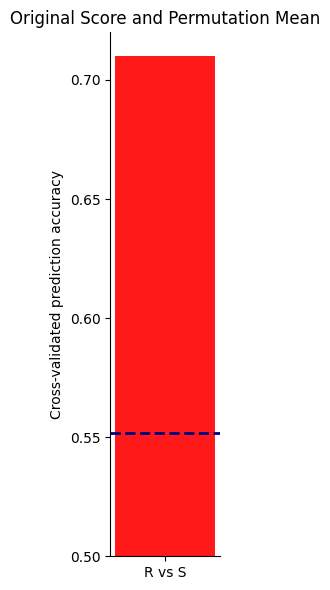

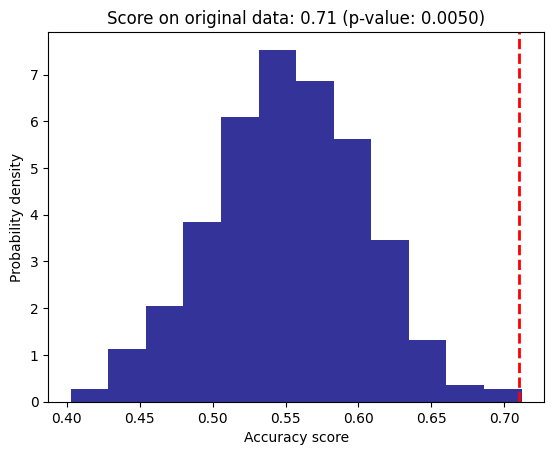

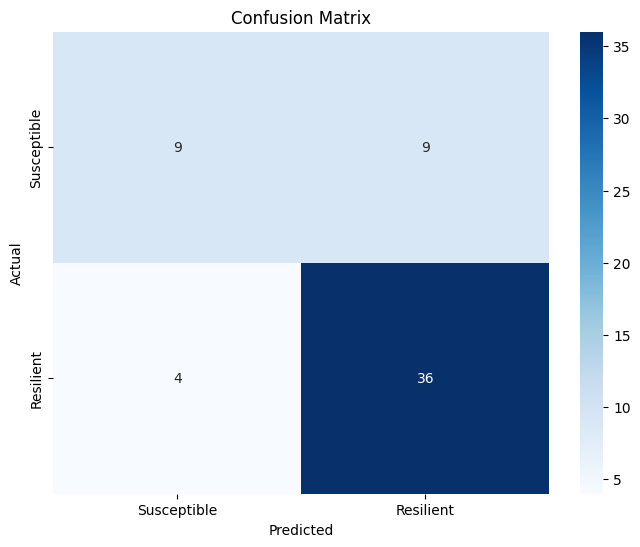

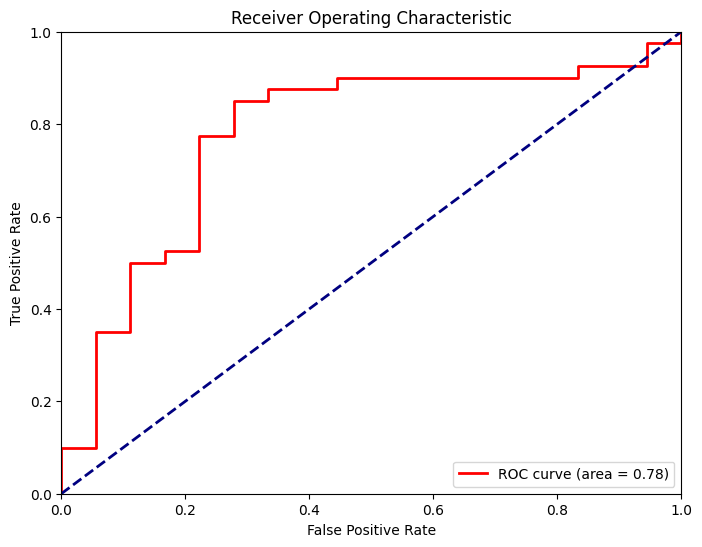

In [69]:
## plot bar graph for true score vs. permutation scores
perm_scores_mean = np.mean(permutation_scores)  # Calculate the average of permutation scores

# Create a bar for the true score
fig, ax = plt.subplots(figsize=(2, 6))
ax.bar(['R vs S'], [score], color='red', alpha=0.9, width=0.1)

# Add a dashed line for the average permutation score
ax.axhline(perm_scores_mean, color='navy', linestyle='dashed', linewidth=2)

# Annotate the mean permutation score on the plot
#plt.text('Original Score', perm_scores_mean, f'Permutation Mean: {perm_scores_mean:.2f}', ha='right', va='bottom')

# Set the limits for the y-axis starting from 0.5
ax.set_ylim(0.5, max(score, perm_scores_mean) + 0.01)
ax.set_yticks(np.arange(0.5, max(score, perm_scores_mean) + 0.01, 0.05))
ax.set_ylabel('Cross-validated prediction accuracy')
ax.set_title('Original Score and Permutation Mean')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Plot the permutation test histogram
plt.hist(permutation_scores, bins=12, density=True, alpha=0.8, color='navy')
plt.axvline(score, color='red', linestyle='dashed', linewidth=2)
plt.title(f'Score on original data: {score:.2f} (p-value: {pvalue:.4f})')
plt.xlabel('Accuracy score')
plt.ylabel('Probability density')
plt.show()


## Plot confusion matrix 
# Fit the model on the whole dataset for plotting confusion matrix and ROC curve
model_pipeline.fit(X, y)
y_pred = model_pipeline.predict(X)
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Susceptible', 'Resilient'], yticklabels=['Susceptible', 'Resilient'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



## Compute and plot ROC curve and ROC area
y_pred_prob = model_pipeline.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(qda, X, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=2)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)

fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

In [10]:
dddd = permutation_scores.mean()

### 1.이진분류 알고리즘 (QDA, LDA,...)

In [10]:
if class_two:
    # Prepare data
    X = []  # Features
    y = []  # Response
    for file_name, data in data_moseq.items():
        relative_frequency_values = list(data['syllables relative frequency'].values())
        X.append(relative_frequency_values)
        response_value = data['class']
        y.append(response_value)

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

1-1. QDA (Quadratic Discriminant Analysis) model training

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    qda.fit(X_train, y_train) # 모델 훈련
    predictions = qda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


syllable 절대값(syllables_reindexed)에 표준화(standardization) 적용 -> QDA    (syllable 상대빈도 말고)

1-1-2. PCA -> QDA

In [ ]:
# from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.model_selection import permutation_test_score
# from sklearn.metrics import accuracy_score
# from sklearn.decomposition import PCA

# # Prepare data
# X = []  # Features
# y = []  # Response
# for file_name, data in data_moseq.items():
#     relative_frequency_values = list(data['syllables relative frequency'].values())
#     X.append(relative_frequency_values)
#     response_value = data['class']
#     y.append(response_value)

# # Convert to NumPy arrays
# X = np.array(X)
# y = np.array(y)

# # 주성분 분석으로 데이터 축소
# pca = PCA(n_components=6)
# X_pca = pca.fit_transform(X)

# # 분석기 초기화
# clf_qda = QuadraticDiscriminantAnalysis()

# # Repeated Stratified K-Fold 객체 생성
# cv_rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)

# # Cross-validation scores
# scores_cv = cross_val_score(clf_qda, X_pca, y, cv=cv_rskf)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_cv.mean(), scores_cv.std()))
# clf_qda.fit(X_pca, y)

# ## Visualize the QDA classifier
# # Fit PCA with 2 components for visualization
# pca2 = PCA(n_components=2)
# X_pca2 = pca2.fit_transform(X)

# # Decision boundary in the space of the first two principal components
# x_min, x_max = X_pca2[:, 0].min() - 0.5, X_pca2[:, 0].max() + 0.5
# y_min, y_max = X_pca2[:, 1].min() - 0.5, X_pca2[:, 1].max() + 0.5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))

# # Transform grid using the same 2D PCA transformation
# grid = np.c_[xx.ravel(), yy.ravel()]
# grid_pca = pca.transform(pca2.inverse_transform(grid))

# # Predict on the 10D transformed grid
# Z = clf_qda.predict(grid_pca)
# Z = Z.reshape(xx.shape)

# # Plot
# # plt.contourf(xx, yy, Z, alpha=0.8)
# scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, edgecolors='k', marker='o', s=50)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Quadratic Discriminant Analysis')
# plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
# plt.show()

1-2. Permutation test

Model score: 0.7090892857142856
Permutation test p-value: 0.04395604395604396


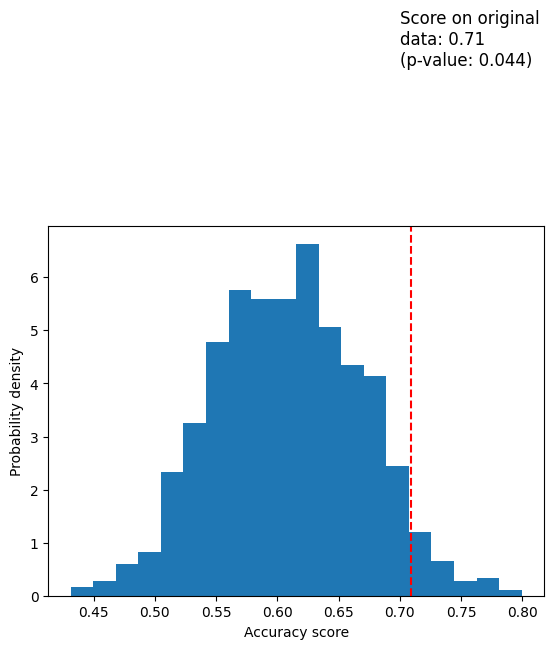

In [124]:
import matplotlib.pyplot as plt
# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(qda, X, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=2)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)

fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

1-3. Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix

ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()
 
tn, fp, fn, tp = confusion_matrix(list(y_test), list(predictions), labels=[0, 1]).ravel()
 
print('True Positive :', tp)
print('True Negative :', tn)
print('False Positive :', fp)
print('False Negative :', fn)
print("Precision score", precision_score(y_test,predictions))

2-1. Linear discriminant analysis

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score

# Prepare data
X = []  # Features
y = []  # Response
for file_name, data in data_moseq.items():
    relative_frequency_values = list(data['syllables relative frequency'].values())
    X.append(relative_frequency_values)
    response_value = data['class']
    y.append(response_value)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# 분석기 초기화
lda = LinearDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1000, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lda.fit(X_train, y_train) # 모델 훈련
    predictions = lda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("Average accuracy: ", np.mean(scores))

# 분석기 초기화
lda = LinearDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(lda, X, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=1)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)


### 3. 회귀 알고리즘 (Regression)

In [58]:
# Prepare data
X = []  # Features
y = []  # Response
for file_name, data in data_moseq.items():
    predictors = list(data['syllables relative frequency'].values())
    X.append(predictors)
    response_value = data['SI ratio']
    y.append(response_value)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

3-1. 라쏘 회귀 (정규화 선형회귀)

In [ ]:
from sklearn.preprocessing import StandardScaler

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 라쏘 회귀 모델 정의 (alphas 매개변수를 조정하여 다양한 값 시도)
lasso = LassoCV(cv=5, alphas=np.logspace(-8, 1, 13),  max_iter=100000)  # 알파 범위 조정

# 모델 학습
lasso.fit(X_train_scaled, y_train)

# 특성 중요도
feature_importance = lasso.coef_

3-2. 랜덤 포레스트 회귀. (비선형. 특성중요도 추출 가능)

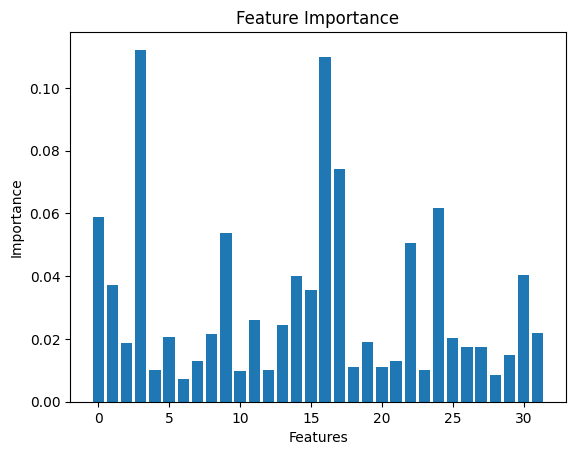

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터를 훈련 및 테스트 세트로 분할 (예시로 X와 y를 사용합니다)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 생성 및 훈련
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# 예측 수행
predictions = model.predict(X_test)

# 특성 중요도 추출
feature_importances = model.feature_importances_

# 특성 중요도 시각화
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# 교차 검증을 사용하여 R^2 점수 계산
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # cv는 분할 수
print("Cross-Validation R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))

# 테스트 세트에서 MSE 계산
mse_score = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_score)


Cross-Validation R^2 scores: [-20.67830117  -0.11698533  -0.35721482  -0.38699736  -4.96792097]
Average R^2 score: -5.301483929436
Mean Squared Error: 0.05255629572850005
